In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

In [60]:
import autograd
import autograd.numpy as np


def loss(w, x):
  return -np.log(1.0 / (1 + np.exp(-np.dot(x, w))))


x = np.array([1, -1])
w = np.array([1.0, 0.5])

grad_loss = autograd.grad(loss)
print(loss(w, x))
print(grad_loss(w, x))


0.47407698418010663
[-0.37754067  0.37754067]


In [61]:
import torch

x = torch.tensor([1, -1], dtype=torch.float)
w = torch.tensor([1.0, 0.5], dtype=torch.float, requires_grad=True)

loss = -torch.dot(x, w).sigmoid().log()
loss.backward()
print(loss.item())
print(w.grad)


0.4740769565105438
tensor([-0.3775,  0.3775])


In [62]:
import tensorflow as tf

x = tf.constant([1, -1], dtype=tf.float32, name='x')
w = tf.Variable([1.0, 0.5], dtype=tf.float32, name='w')

with tf.GradientTape() as tape:
  loss = -tf.math.log(tf.math.sigmoid(tf.tensordot(x, w, 1)))

print(loss.numpy())
print(tape.gradient(loss, w))


0.47407696
tf.Tensor([-0.37754062  0.37754062], shape=(2,), dtype=float32)


In [63]:
""" import jax
import jax.numpy as jnp


def loss(w, x):
  return -jnp.log(1.0 / (1 + jnp.exp(-jnp.dot(x, w))))


x = jnp.array([1, -1], dtype=jnp.float32)
w = jnp.array([1.0, 0.5], dtype=jnp.float32)

grad_loss = jax.jit(jax.grad(loss))
print(loss(w, x))
print(grad_loss(w, x))
 """

' import jax\nimport jax.numpy as jnp\n\n\ndef loss(w, x):\n  return -jnp.log(1.0 / (1 + jnp.exp(-jnp.dot(x, w))))\n\n\nx = jnp.array([1, -1], dtype=jnp.float32)\nw = jnp.array([1.0, 0.5], dtype=jnp.float32)\n\ngrad_loss = jax.jit(jax.grad(loss))\nprint(loss(w, x))\nprint(grad_loss(w, x))\n '

In [64]:
import torch


def init_graph(X, dpi=100, figsize=(6, 6)):
  xmin, xmax = X[:, 0].min()-0.5, X[:, 0].max()+0.5
  ymin, ymax = X[:, 1].min()-0.5, X[:, 1].max()+0.5

  fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  ax.set_xlim(xmin, xmax)
  ax.set_ylim(ymin, ymax)
  return fig, ax


def plot_data(ax, X, Y):
  I = np.where(Y == 0)
  ax.scatter(X[I, 0], X[I, 1], c='tab:blue', marker='_')
  I = np.where(Y == 1)
  ax.scatter(X[I, 0], X[I, 1], c='tab:red', marker='+')


def draw_heatmap(fig, ax, func, step=1, N=1024):
  xmin, xmax = ax.get_xlim()
  ymin, ymax = ax.get_ylim()

  XX, YY = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))
  XY = np.vstack([XX.ravel(), YY.ravel()]).T

  X_ = torch.from_numpy(XY).type(dtype)
  Y_ = func(X_).detach().numpy().copy()
  C = Y_.reshape(XX.shape)

  vmin, vmax = C.min(), C.max()
  vmin = ((vmin // step) - 1) * step
  vmax = ((vmax // step) + 1) * step
  width = max(abs(vmin), abs(vmax))

  mesh = ax.pcolormesh(XX, YY, C, norm=matplotlib.colors.Normalize(vmin=-width, vmax=width), cmap='bwr', shading='auto', alpha=0.2)
  cbar = fig.colorbar(mesh, ax=ax)
  cbar.set_label('Output value')

  cont = ax.contour(XX, YY, C, colors='tab:gray', linewidths=0.5, linestyles='dashed', levels=np.arange(vmin, vmax+1, step))
  cont.clabel(fmt='%1.1f')


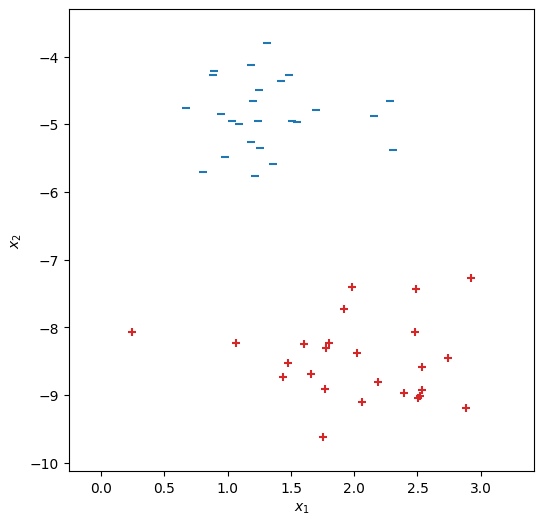

In [65]:
from sklearn.datasets import make_blobs
D = make_blobs(n_samples=50, centers=2, random_state=129, cluster_std=.6)

fig, ax = init_graph(D[0])
plot_data(ax, D[0], D[1])
plt.show()

In [66]:
from torch.utils.data import TensorDataset, DataLoader

dtype = torch.float
X = torch.from_numpy(D[0]).type(dtype)
Y = torch.from_numpy(D[1].reshape(-1, 1)).type(dtype)

In [67]:
X[:4]

tensor([[ 2.4885, -7.4323],
        [ 1.4338, -8.7279],
        [ 2.1874, -8.8029],
        [ 1.1995, -4.6490]])

In [68]:
Y[:4]

tensor([[1.],
        [1.],
        [1.],
        [0.]])

In [69]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Parameters of the single-layer neural network.
w = torch.randn(2, 1, dtype=dtype, requires_grad=True)
b = torch.randn(1, dtype=dtype, requires_grad=True)

H = []
eta = 0.01
for t in range(1000):
  sumloss = 0.
  for x, y in loader:
    y_hat = (x.matmul(w) + b).sigmoid()
    l = y * y_hat + (1 - y) * (1 - y_hat)
    loss = -l.log().sum()
    sumloss += loss.item()

    loss.backward()
    with torch.no_grad():
      w -= eta * w.grad
      b -= eta * b.grad
      w.grad.zero_()
      b.grad.zero_()

  H.append(sumloss)


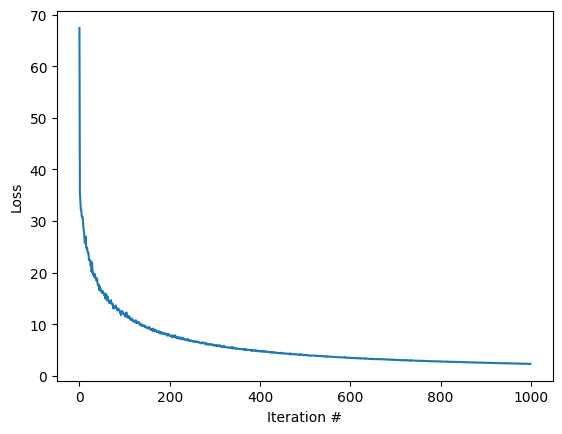

In [70]:
fig, ax = plt.subplots()
ax.plot(H)
ax.set_xlabel('Iteration #')
ax.set_ylabel('Loss')
plt.show()

In [71]:
w, b

(tensor([[ 0.3102],
         [-1.9325]], requires_grad=True),
 tensor([-13.1249], requires_grad=True))

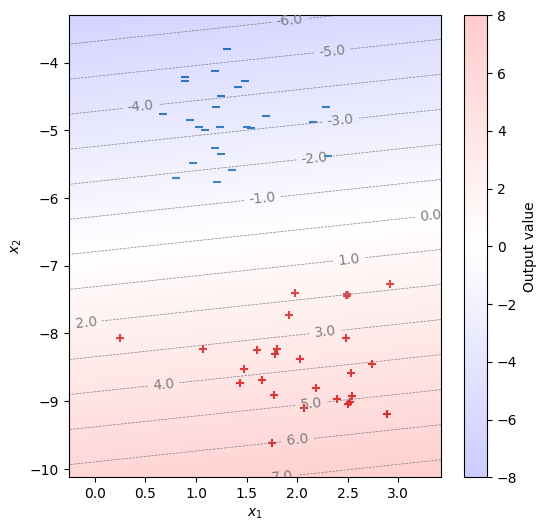

In [72]:
def model(x):
  return x.matmul(w) + b


fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()


In [73]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Single-layer NN: 2 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True),
)
loss_fn = torch.nn.BCEWithLogitsLoss()

eta = 0.1
for t in range(1000):
  for x, y in loader:
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    model.zero_grad()
    loss.backward()

    with torch.no_grad():
      for param in model.parameters():
        param -= eta * param.grad


In [74]:
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

In [75]:
model.state_dict()

OrderedDict([('0.weight', tensor([[ 0.5630, -2.5226]])),
             ('0.bias', tensor([-17.4675]))])

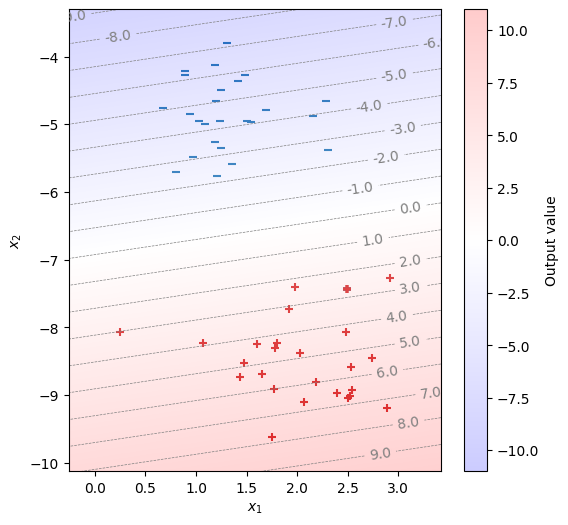

In [76]:
fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

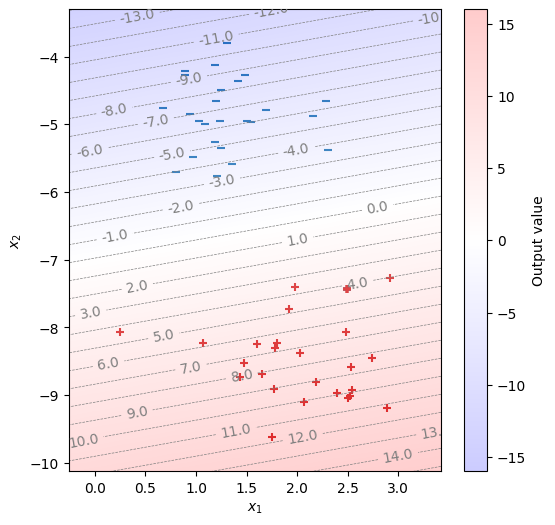

In [77]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Single-layer NN: 2 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True),
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
  for x, y in loader:
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()


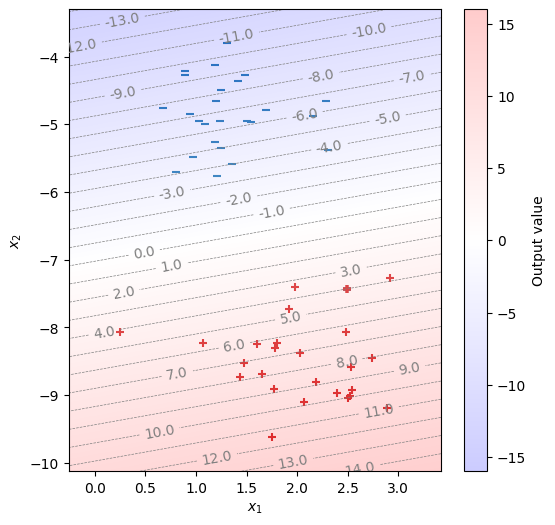

In [78]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Define a neural network as a class.


class SingleLayerNN(torch.nn.Module):
  def __init__(self, d_in, d_out):
    super().__init__()
    self.linear1 = torch.nn.Linear(d_in, d_out, bias=True)

  def forward(self, x):
    return self.linear1(x)


model = SingleLayerNN(2, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
  for x, y in loader:
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()


In [79]:
model.state_dict()

OrderedDict([('linear1.weight', tensor([[ 0.9953, -3.7282]])),
             ('linear1.bias', tensor([-26.1820]))])

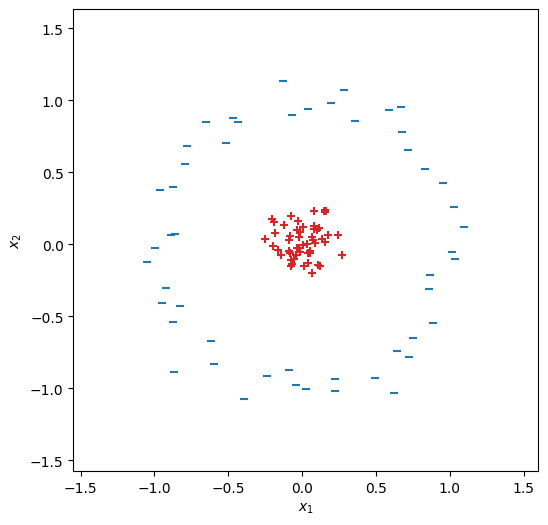

In [80]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_circles

D = make_circles(100, factor=.1, noise=.1, random_state=9)

dtype = torch.float
X = torch.from_numpy(D[0]).type(dtype)
Y = torch.from_numpy(D[1].reshape(-1, 1)).type(dtype)

fig, ax = init_graph(X)
plot_data(ax, X, Y)
plt.show()


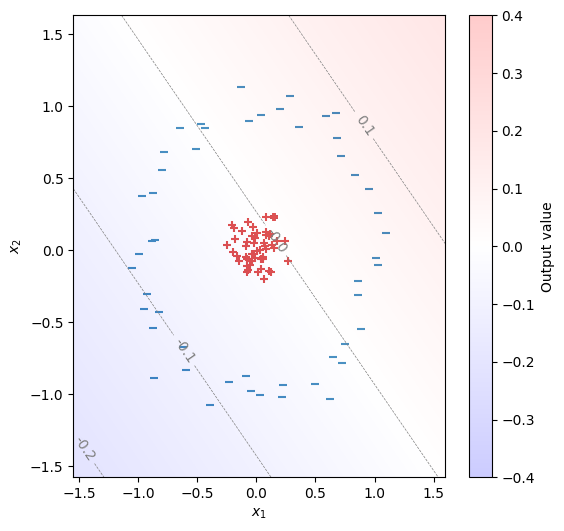

In [81]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Single-layer NN: 2 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True),
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
  for x, y in loader:
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model, 0.1)
plt.show()


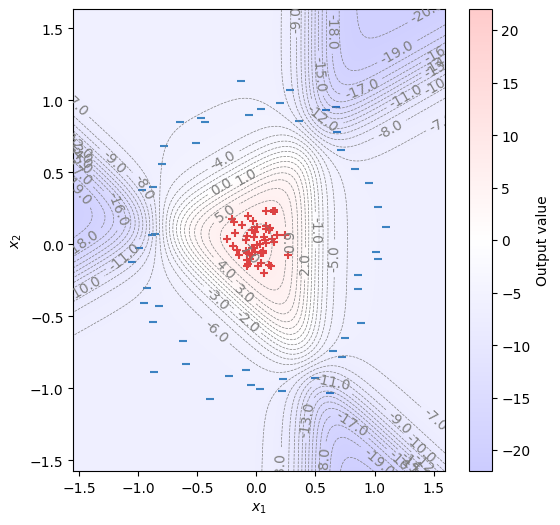

In [82]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Two-layer NN: 2 -> 4 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 4, bias=True),
    torch.nn.Sigmoid(),
    torch.nn.Linear(4, 1, bias=True),
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
  for x, y in loader:
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()
